### Imports

In [188]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import re
import nltk
import logging

from sklearn import feature_extraction
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (plot_roc_curve, classification_report, roc_auc_score, average_precision_score,
confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve)

### Configs

In [189]:
configs = {
    "run_name": "template_run",
    "test_year": 2020,
    # Model Type, will support LR, SVC, RandomForest, and NB
    'model': 'lr',
    # Vectorizer Type (CV, TFIDF)
    'vectorizer': {'type': 'cv', 
                    'ngrams': (1,3),
                   'binary': False,
                   'stopwords': 'english',
                   'max_df': 0.8,
                   'min_df': 10
                  },
    'grid_search': True, # If true, your other hyperparemeters should be in a list.
    'hyperparameters': {
        # Change these based on your model.
        "C": [0.001, 0.01, 0.1, 1, 10],
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "max_iter": [100]
    }
}

configs

{'run_name': 'template_run',
 'test_year': 2020,
 'model': 'lr',
 'vectorizer': {'type': 'cv',
  'ngrams': (1, 3),
  'binary': False,
  'stopwords': 'english',
  'max_df': 0.8,
  'min_df': 10},
 'grid_search': True,
 'hyperparameters': {'C': [0.001, 0.01, 0.1, 1, 10],
  'solver': ['lbfgs'],
  'penalty': ['l2'],
  'max_iter': [100]}}

In [190]:
ts = str(datetime.datetime.now())[:19].replace(":","-")
logging.basicConfig(filename = f"../logs/{configs['run_name']}_{ts}.log", level=logging.INFO)

In [191]:
logging.info(configs)

### Data Loading and Splitting

In [192]:
data = pd.read_csv('../data/combined_clean.csv', sep = "|")
print(data.shape)
logging.info(f"Date shape before removing duplicates {data.shape}")
data = data.drop_duplicates().reset_index(drop = True)
print(data.shape)
logging.info(f"Date shape after removing duplicates {data.shape}")


(215013, 4)
(211631, 4)


In [193]:
data['clean'] = data['clean'].astype('U')
data['year'] = data['year'].astype(int)

In [194]:
test_year = configs['test_year']

train = data.loc[data['year'] < test_year]
test = data.loc[data['year'] == test_year]

print(train[train.is_sarcastic == 0].shape)
print(train[train.is_sarcastic == 1].shape)

(159752, 4)
(17813, 4)


In [195]:
from sklearn.utils import resample
df_majority = train[train.is_sarcastic == 0]
df_minority = train[train.is_sarcastic == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=round(df_majority.shape[0])    # to match majority class
                                 ) # reproducible results
 
# Combine majority class with upsampled minority class
train = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
train.is_sarcastic.value_counts()

1    159752
0    159752
Name: is_sarcastic, dtype: int64

In [196]:
train_sarcastic_pct = train['is_sarcastic'].mean()*100
test_sarcastic_pct = test['is_sarcastic'].mean()*100

print(f"Train has {train.shape[0]} records, {round(train_sarcastic_pct,2)}% are sarcastic headlines")
print(f"Test has {test.shape[0]} records, {round(test_sarcastic_pct,2)}% are sarcastic headlines")

logging.info(f"Train has {train.shape[0]} records, {round(train_sarcastic_pct,2)}% are sarcastic headlines")
logging.info(f"Test has {test.shape[0]} records, {round(test_sarcastic_pct,2)}% are sarcastic headlines")

Train has 319504 records, 50.0% are sarcastic headlines
Test has 34066 records, 14.56% are sarcastic headlines


In [197]:
X_train = train['clean']
y_train = train['is_sarcastic']

X_test = test['clean']
y_test = test['is_sarcastic']

### Vectorization

Please adjust the configs or add other data processing steps here.

In [198]:
print("Please make sure your vectorizer is a valid option or add the functionality.")
print('Vectorizer is what converts the text into numerical entries')

if configs['vectorizer']['type'] == "cv":
    vectorizer = feature_extraction.text.CountVectorizer(
                                             lowercase = True,
                                             strip_accents = 'ascii',
                                             stop_words = configs['vectorizer']['stopwords'],
                                             ngram_range = configs['vectorizer']['ngrams'],
                                             max_df = configs['vectorizer']['max_df'],
                                             min_df = configs['vectorizer']['min_df'],
                                             binary = configs['vectorizer']['binary']
    )
                                                        
if configs['vectorizer']['type'] == "tfidf":
    vectorizer = feature_extraction.text.TfidfVectorizer(
                                             lowercase = True,
                                             strip_accents = 'ascii',
                                             stop_words = configs['vectorizer']['stopwords'],
                                             ngram_range = configs['vectorizer']['ngrams'],
                                             max_df = configs['vectorizer']['max_df'],
                                             min_df = configs['vectorizer']['min_df'],
                                             binary = configs['vectorizer']['binary']
    )
    
assert(vectorizer)
vectorizer

logging.info(vectorizer)
print(vectorizer)

Please make sure your vectorizer is a valid option or add the functionality.
Vectorizer is what converts the text into numerical entries
CountVectorizer(max_df=0.8, min_df=10, ngram_range=(1, 3), stop_words='english',
                strip_accents='ascii')


In [199]:
%%time
print("Fitting Vectorizer and Transform Train & Test")
X_train_transformed =  vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

Fitting Vectorizer and Transform Train & Test
CPU times: user 9.64 s, sys: 407 ms, total: 10 s
Wall time: 10.2 s


### Modeling

In [200]:
if configs['grid_search']:
    if configs['model'] == "lr":
        model = LogisticRegression()
    if configs['model'] == "rf":
        model = RandomForestClassifier()
    if configs['model'] == "bnb":
        model = BernoulliNB()
    if configs['model'] == "mnb":
        model = MultinomialNB()
    if configs['model'] == 'svc':
        model = SVC()

    grid_search = GridSearchCV(model, configs['hyperparameters'])
    
logging.info(grid_search)
grid_search

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100],
                         'penalty': ['l2'], 'solver': ['lbfgs']})

In [201]:
grid_search.fit(X_train_transformed, y_train)

/Users/valeriehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/valeriehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100],
                         'penalty': ['l2'], 'solver': ['lbfgs']})

In [202]:
be = grid_search.best_estimator_
logging.info("Best Model:")
logging.info(be)
be

LogisticRegression(C=10)

### Evaluation

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     29107
           1       0.65      0.52      0.58      4959

    accuracy                           0.89     34066
   macro avg       0.78      0.74      0.76     34066
weighted avg       0.88      0.89      0.88     34066



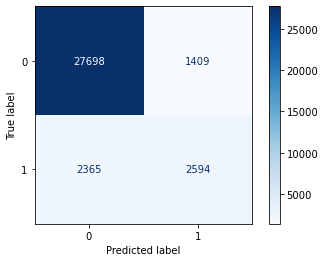

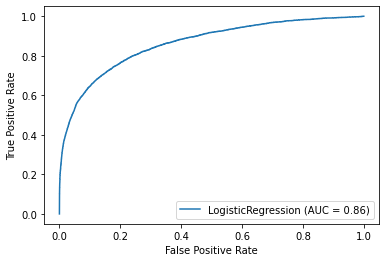

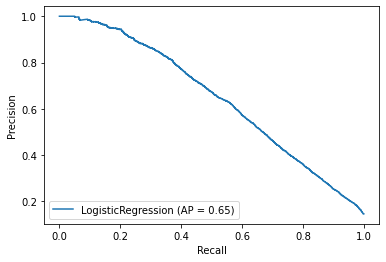

In [203]:
be_preds = be.predict(X_test_transformed)
be_probs = be.predict_proba(X_test_transformed)[:,1]

print(classification_report(y_test, be_preds))

plot_confusion_matrix(be, X_test_transformed, y_test, cmap = plt.cm.Blues)
plt.show()

plot_roc_curve(be, X_test_transformed, y_test)
plt.show()

plot_precision_recall_curve(be, X_test_transformed, y_test)
plt.show()

## Save Information

In [204]:
logging.info(grid_search.cv_results_)

In [205]:
auc_score = roc_auc_score(y_test, be_probs)
avg_precision = average_precision_score(y_test, be_probs)
cm = confusion_matrix(y_test, be_preds)

In [206]:
logging.info(f'AUC: {auc_score}')
logging.info(f'Average Precision: {avg_precision}')
logging.info('Confusion Matrix:')
logging.info(cm)

In [207]:
logging.info("Classification Report:")
logging.info(classification_report(y_test, be_preds))

In [214]:
upsampling_data = pd.read_excel('../data/Precision_Recall.xlsx')

In [215]:
upsampling_data

,Proportion,Precision for Not Satirical,Recall for Not Satirical,F-1 Score for Not Satirical,Precision for Satirical,Recall for Satirical,F-1 Score for Satirical
0,0.2,0.92,0.97,0.95,0.74,0.52,0.61
1,0.3,0.93,0.94,0.94,0.64,0.58,0.61
2,0.4,0.93,0.94,0.93,0.62,0.58,0.60
3,0.5,0.93,0.93,0.93,0.61,0.60,0.60
4,0.6,0.93,0.93,0.93,0.61,0.59,0.60
5,0.7,0.93,0.94,0.93,0.62,0.58,0.60
6,0.8,0.93,0.94,0.93,0.62,0.56,0.59
7,0.9,0.92,0.95,0.94,0.65,0.54,0.59
8,1.0,0.92,0.95,0.94,0.65,0.52,0.58
